**Описание проекта**

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагается два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо произвести предварительный анализ тарифов на небольшой выборке клиентов.

*Имеющиеся данные:* данные 500 пользователей «Мегалайна» (кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год).

*Цель исследования:* определение тарифа, который приносит больше прибыли. 

**Описание тарифов**

*Тариф «Смарт»*
 * Ежемесячная плата: 550 рублей
 * Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
 * Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей

*Тариф «Ультра»*
 * Ежемесячная плата: 1950 рублей
 * Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
 * Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей

*Примечание:*
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

# 1. Обзор данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import math

users = pd.read_csv('users.csv')
calls = pd.read_csv('calls.csv')
messages = pd.read_csv('messages.csv')
internet = pd.read_csv('internet.csv', index_col=0)
tariffs = pd.read_csv('tariffs.csv')

**Таблица users (информация о пользователях):**
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tarif — название тарифного плана

In [2]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [3]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Необходимо перевести churn_date, reg_date на тип даты. Столбец churn_date имеет много пропусков, но в описанни указано, что, если  значение пропущено, то тариф ещё действовал на момент выгрузки данных, поэтому эти пропуски оставим без изменений.

**Таблица calls (информация о звонках):**

* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Необходимо перевести call_date на тип даты. Пропусков нет.

**Таблица messages (информация о сообщениях):**
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

In [6]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [7]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Необходимо перевести message_date на тип даты. Пропусков нет.

**Таблица internet (информация об интернет-сессиях):**
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [9]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Необходимо перевести session_date на тип даты. Пропусков нет. Есть лишний столбец, который можно убрать.

**Таблица tariffs (информация о тарифах):**
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [10]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [11]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Все ок.

# 2. Предобработка данных

Приведем данные к нужным типам

In [12]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

**Вычисление параметров для каждого пользователя**

Добавим к каждой таблице колонку month (месяц совершения действия).

In [13]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages["message_date"].dt.month
internet['month'] = internet['session_date'].dt.month

Округлим данные по звонкам до минут и приведем значения к целочисленным: </font>

In [14]:
calls['duration'] = calls['duration'].apply(np.ceil).astype(int)

Рассчитаем параметры с помощью сводных таблиц.

Количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя:

In [15]:
calls_pivot = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc={'count',sum})
calls_pivot.columns = ['calls_count', 'calls_duration'] 
calls_pivot.head(10)

calls_count  calls_duration
user_id month                             
1000    5               22             159
        6               43             172
        7               47             340
        8               52             408
        9               58             466
        10              57             350
        11              43             338
        12              46             333
1001    11              59             430
        12              63             414

Количество отправленных сообщений по месяцам для каждого пользователя:

In [16]:
messages_pivot = messages.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count')
messages_pivot.columns = ['messages_count'] 
messages_pivot.head(10)

messages_count
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57
        10                 73
        11                 58
        12                 70
1002    6                   4
        7                  11

Объем израсходованного интернет-трафика по месяцам для каждого пользователя:

In [17]:
internet_pivot = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc=sum)
internet_pivot.columns = ['mb_used_sum'] 
internet_pivot.head(10)

mb_used_sum
user_id month             
1000    5          2253.49
        6         23233.77
        7         14003.64
        8         14055.93
        9         14568.91
        10        14702.49
        11        14756.47
        12         9817.61
1001    11        18429.34
        12        14036.66

Теперь для удобства переведем Mb в Gb, округлим в большую сторону и сделаем значения целочисленными: </font>

In [18]:
internet_pivot['gb_used_sum'] = (internet_pivot['mb_used_sum'] / 1024).apply(np.ceil).astype(int)

In [19]:
internet_pivot.head(10)

mb_used_sum  gb_used_sum
user_id month                          
1000    5          2253.49            3
        6         23233.77           23
        7         14003.64           14
        8         14055.93           14
        9         14568.91           15
        10        14702.49           15
        11        14756.47           15
        12         9817.61           10
1001    11        18429.34           18
        12        14036.66           14

Теперь объединим все сводные таблицы в единый датафрейм

In [20]:
pivot_full = calls_pivot.merge(messages_pivot, on=['user_id', 'month'], how='outer').merge(internet_pivot, on=['user_id', 'month'], how='outer')
pivot_full.reset_index(inplace=True)
pivot_full.head(10)

,user_id,month,calls_count,calls_duration,messages_count,mb_used_sum,gb_used_sum
0,1000,5,22.0,159.0,22.0,2253.49,3.0
1,1000,6,43.0,172.0,60.0,23233.77,23.0
2,1000,7,47.0,340.0,75.0,14003.64,14.0
3,1000,8,52.0,408.0,81.0,14055.93,14.0
4,1000,9,58.0,466.0,57.0,14568.91,15.0
5,1000,10,57.0,350.0,73.0,14702.49,15.0
6,1000,11,43.0,338.0,58.0,14756.47,15.0
7,1000,12,46.0,333.0,70.0,9817.61,10.0
8,1001,11,59.0,430.0,NaN,18429.34,18.0
9,1001,12,63.0,414.0,NaN,14036.66,14.0


А теперь объединим получившуюся объединенную сводную таблицу с таблицей с информацией о пользователях

In [21]:
clients = users.merge(pivot_full, on=['user_id'], how='outer')

In [22]:
clients.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_count,calls_duration,messages_count,mb_used_sum,gb_used_sum
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,159.0,22.0,2253.49,3.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,43.0,172.0,60.0,23233.77,23.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,47.0,340.0,75.0,14003.64,14.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,52.0,408.0,81.0,14055.93,14.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,58.0,466.0,57.0,14568.91,15.0


In [23]:
clients.isna().sum()

user_id              0
age                  0
churn_date        3027
city                 0
first_name           0
last_name            0
reg_date             0
tariff               0
month                2
calls_count         42
calls_duration      42
messages_count     499
mb_used_sum         13
gb_used_sum         13
dtype: int64

Есть пропущенные значения. Удалим 2 строчки, в которых есть пропуски в столбце month

In [24]:
clients.dropna(subset=['month'], inplace=True)

Заменим пропуски на 0 в столбцах calls_count, calls_duration, messages_count, mb_used_sum

In [25]:
clients['calls_count'].fillna(0,inplace=True)
clients['calls_duration'].fillna(0,inplace=True)
clients['messages_count'].fillna(0,inplace=True)
clients['mb_used_sum'].fillna(0,inplace=True)
clients['gb_used_sum'].fillna(0,inplace=True)

In [26]:
clients.isna().sum()

user_id              0
age                  0
churn_date        3027
city                 0
first_name           0
last_name            0
reg_date             0
tariff               0
month                0
calls_count          0
calls_duration       0
messages_count       0
mb_used_sum          0
gb_used_sum          0
dtype: int64

In [27]:
clients.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_count,calls_duration,messages_count,mb_used_sum,gb_used_sum
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,159.0,22.0,2253.49,3.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,43.0,172.0,60.0,23233.77,23.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,47.0,340.0,75.0,14003.64,14.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,52.0,408.0,81.0,14055.93,14.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,58.0,466.0,57.0,14568.91,15.0


Посчитаем помесячную выручку с каждого пользователя. Напишем функцию:

In [28]:
def get_revenue(row):
    if row['tariff'] == 'smart':
        revenue = 550
        if row['calls_duration'] > 500:
            revenue += (row['calls_duration'] - 500)*3
        if row['messages_count'] > 50:
            revenue += (row['messages_count'] - 50)*3
        if row['gb_used_sum'] > 15:
            revenue += (row['gb_used_sum'] - 15)*200
        
    else:
        revenue = 1950
        if row['calls_duration'] > 3000:
            revenue += (row['calls_duration'] - 3000)
        if row['messages_count'] > 1000:
            revenue += (row['messages_count'] - 1000)
        if row['gb_used_sum'] > 30:
            revenue += (row['gb_used_sum'] - 30)*150
             
    return revenue

clients['revenue'] = clients.apply(get_revenue, axis=1)

In [29]:
clients.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_count,calls_duration,messages_count,mb_used_sum,gb_used_sum,revenue
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,22.0,159.0,22.0,2253.49,3.0,1950.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,43.0,172.0,60.0,23233.77,23.0,1950.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,47.0,340.0,75.0,14003.64,14.0,1950.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,52.0,408.0,81.0,14055.93,14.0,1950.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,58.0,466.0,57.0,14568.91,15.0,1950.0


Посмотрим еще раз на данные с информацией об интернет-сессиях

In [30]:
internet['mb_used'].value_counts()

0.00      19598
335.91        9
447.30        9
197.56        9
199.11        8
          ...  
643.43        1
973.04        1
834.51        1
777.30        1
23.72         1
Name: mb_used, Length: 70003, dtype: int64

In [31]:
internet[internet['mb_used'] == 0]

,id,mb_used,session_date,user_id,month
11,1000_11,0.0,2018-08-28,1000,8
38,1000_38,0.0,2018-11-27,1000,11
46,1000_46,0.0,2018-06-30,1000,6
67,1000_67,0.0,2018-06-16,1000,6
72,1000_72,0.0,2018-06-15,1000,6
...,...,...,...,...,...
149380,1499_141,0.0,2018-12-11,1499,12
149381,1499_142,0.0,2018-11-01,1499,11
149383,1499_144,0.0,2018-11-27,1499,11
149386,1499_147,0.0,2018-10-21,1499,10


Мы видим, что в данных есть 19598 строчек, в которых указано, что было использовано 0 мб интернета. В данном случае можно сделать предположение, что в момент подключения были неполадки с соединением и пользователь так и не вышел в сеть, но сессия уже была сформирована и ей присвоено нулевое значение. Удалим эти строки, так как они могут исказить общую картину.

In [32]:
internet.drop(internet[internet['mb_used'] == 0].index, inplace = True)

# 3. Анализ данных

In [33]:
clients[clients['tariff']=='ultra'].describe()

,user_id,age,month,calls_count,calls_duration,messages_count,mb_used_sum,gb_used_sum,revenue
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,1263.094416,46.834518,8.250761,73.392893,526.623350,49.363452,19468.805208,19.494416,2070.152284
std,140.694908,17.107979,2.871762,43.916853,317.606098,47.804457,10087.170752,9.853511,376.187114
min,1000.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1950.000000
25%,1143.000000,30.000000,6.000000,41.000000,284.000000,6.000000,11770.260000,12.000000,1950.000000
50%,1277.000000,45.000000,9.000000,74.000000,518.000000,38.000000,19308.010000,19.000000,1950.000000
75%,1381.000000,63.000000,11.000000,104.000000,752.000000,79.000000,26837.690000,27.000000,1950.000000
max,1495.000000,75.000000,12.000000,244.000000,1673.000000,224.000000,49745.690000,49.000000,4800.000000


In [34]:
clients[clients['tariff']=='smart'].describe()

,user_id,age,month,calls_count,calls_duration,messages_count,mb_used_sum,gb_used_sum,revenue
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000
mean,1246.506505,46.556303,8.346792,58.463437,417.934948,33.384029,16208.386990,16.328847,1289.973531
std,146.119496,16.353371,2.920316,25.939858,190.313730,28.227876,5870.476681,5.747061,818.404367
min,1001.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,550.000000
25%,1121.000000,32.000000,6.000000,40.000000,282.000000,10.000000,12643.010000,13.000000,550.000000
50%,1239.000000,47.000000,9.000000,60.000000,422.000000,28.000000,16506.840000,17.000000,1023.000000
75%,1376.000000,62.000000,11.000000,76.000000,545.000000,51.000000,20042.930000,20.000000,1750.000000
max,1499.000000,75.000000,12.000000,198.000000,1435.000000,143.000000,38552.450000,38.000000,6770.000000


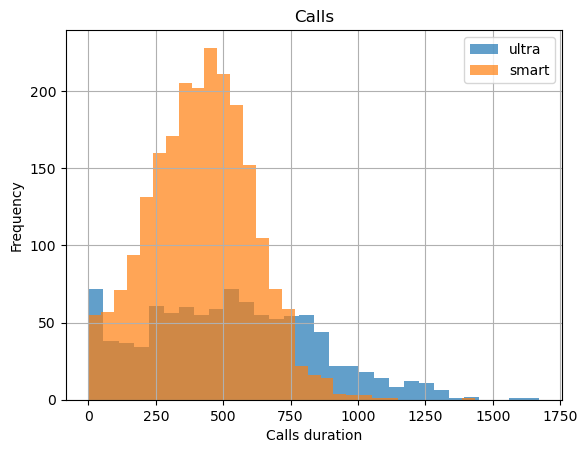

In [35]:
plt.hist(clients[clients['tariff']=='ultra']['calls_duration'], alpha=0.7, bins=30, label='ultra')
plt.hist(clients[clients['tariff']=='smart']['calls_duration'], alpha=0.7, bins=30, label='smart')
plt.xlabel('Calls duration')
plt.ylabel('Frequency')
plt.title('Calls')
plt.legend()
plt.grid()

На гистограмме отображено распределение продолжительности разговоров пользователей двух тарифов в месяц.
Пользователи тарифа ultra разговаривают дольше, чем пользователи тарифа smart. Никто из пользователей тарифа ultra не выходит за пределы своего бесплатного лимита, в то время как некоторая часть пользователей тарифа smart вынуждена платить поминутно. Среднее значение продолжительности разговоров для тарифа ultra - 527 минут, для smart - 418 минут. Стандартное отклонение 318 и 190 соответсвенно.

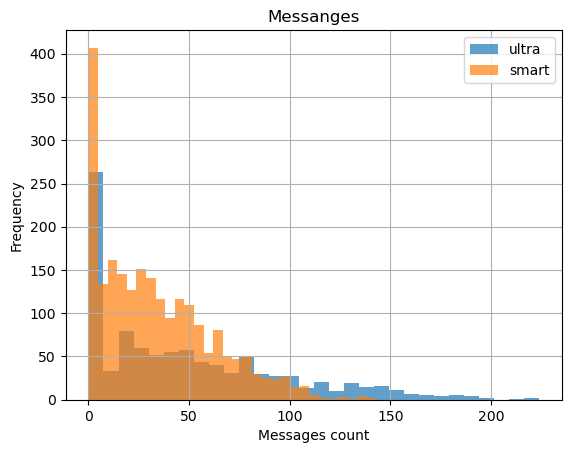

In [36]:
plt.hist(clients[clients['tariff']=='ultra']['messages_count'], alpha=0.7, bins=30, label='ultra')
plt.hist(clients[clients['tariff']=='smart']['messages_count'], alpha=0.7, bins=30, label='smart')
plt.xlabel('Messages count')
plt.ylabel('Frequency')
plt.title('Messanges')
plt.legend()
plt.grid()

На гистограмме отображено распределение количества отправленных сообщений пользователей двух тарифов в месяц. 
Сразу бросается в глаза, что большое количество пользователей обоих тарифов не отправляют сообщения в принципе (пик около 0). 
В среднем, пользователи тарифа ultra отправляют 49 сообщений в день, тарифа smart - 33 сообщения. Стандартное отклонение: 47.8 и 28.2 соответственно. 

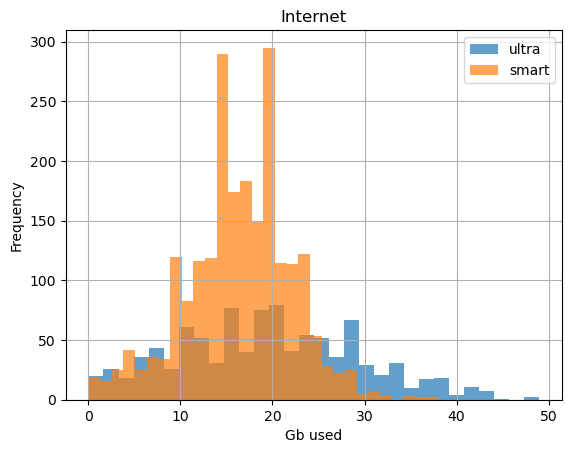

In [37]:
plt.hist(clients[clients['tariff']=='ultra']['gb_used_sum'], alpha=0.7, bins=30, label='ultra')
plt.hist(clients[clients['tariff']=='smart']['gb_used_sum'], alpha=0.7, bins=30, label='smart')
plt.xlabel('Gb used')
plt.ylabel('Frequency')
plt.title('Internet')
plt.legend()
plt.grid()

На гистограмме отображено распределение объема интернет-трафика (гб) пользователей двух тарифов в месяц.
В среднем, пользователям тарифа ultra требуется 19 гб трафика, smart - 16 гб. Большому количеству пользователей обоих тарифов не хватает своего бесплатного пакета и им приходится платить дополнительно за каждый гигабайт. Стандартное отклонение по тарифу ultra - 9.7 гб, smart - 5.7 гб.

# 4. Проверка гипотез

*4.1 Средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются*

Нулевая гипотеза: средняя выручка пользователей тарифов "Ультра" и "Смарт" **равны**.

Альтернативная гипотеза: средняя выручка пользователей тарифов "Ультра" и "Смарт" **не равны**.

In [38]:
ultra_revenue = clients[clients['tariff']=='ultra']['revenue']
smart_revenue = clients[clients['tariff']=='smart']['revenue']
alpha = 0.05
results =  st.ttest_ind(
    ultra_revenue, 
    smart_revenue)
print('p-значение:',results.pvalue) 

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


Выше мы сравнили среднее двух генеральных совокупностей с помощью t-теста.

Критический уровень статистической значимости: 5%. 

P-value оказался намного меньше 5% (что значит, что вероятность получить такое или большее различие случайно практически равно нулю), поэтому мы отвергаем нулевую гипотезу в пользу альтернативной гипотезы (средняя выручка пользователей двух тарифов отличается). 

*4.2 Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов*

Нулевая гипотеза: средняя выручка пользователей из Москвы **равна** выручке пользователей из других регионов.

Альтернативная гипотеза: средняя выручка пользователей из Москвы **не равна** выручке пользователей из других регионов.

In [39]:
revenue_moscow = clients[clients['city']=='Москва']['revenue']
revenue_othercities = clients[clients['city']!='Москва']['revenue']
alpha = 0.05
results =  st.ttest_ind(
    revenue_moscow, 
    revenue_othercities)
print('p-значение:',results.pvalue) 

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


Выше мы сравнили среднее двух генеральных совокупностей с помощью t-теста.

Критический уровень статистической значимости: 5%.

P-value оказался 48% (что значит, что вероятность получить такое или большее различие случайно 48%). Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками пользователей из Москвы и других городов, поэтому мы не можем отвергнуть нулевую гипотезу.

# 5. Вывод

В процессе работы были проанализированы данные о поведении клиентов компании "Мегалайн": проведена предобработка и анализ данных и проверены две гипотезы.

В ходе предобработки были обнаружены значения, которые необходимо было перевести в правильный тип (ошибочно были указаны данные, связанные с датой), были проверены и обработаны пропущенные значения, найдена и обработана ошибка, связанная с нулевыми значениями в таблице с интернет-трафиком.

В ходе анализа поведения клиентов оператора были получены следующие выводы:

* Пользователи тарифа ultra разговаривают дольше, чем пользователи тарифа smart.

* Пользователи тарифа ultra не выходят за пределы своего бесплатного лимита, в то время как некоторая часть пользователей тарифа smart вынуждена платить поминутно.

* Пользователи тарифа смарт оправляют в среднем на 16 сообщений в день меньше, чем пользователи тарифа ультра. 

* Большое количество пользователей обоих тарифов вовсе не пользуется сервисом отправки сообщений. 

* Пользователи обоих тарифов активно пользуются интернетом и многим не хватает своего бесплатного пакета и поэтому пользователи вынуждены платить дополнительно за каждый гигабайт. В среднем, пользователям тарифов ultra и smart требуется 19 и 16 гб трафика соответственно.

* Компания получает больше прибыли от тарифа ultra, чем от тарифа smart: 2070 руб и 1290 руб в среднем от каждого пользователя соответственно.

После проверки 2х гипотез (1. Средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются; 2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов) мы пришли к выводу, что средняя выручка пользователей двух тарифов различается, а регион, в котором проживают клиенты, не оказывает влияния на это различие.

В качестве рекомендаций для компании "Мегалайн" можно выдвинуть слудующие тезисы:
* Сосредоточить усилия на продвижении тарифов Ultra, так как он приносит больше прибыли.
* Создать мотивацию для пользователей тарифа smart к переходу на тариф ultra, повысив стоимость минуты разговора и интернет-трафика сверх ежемесячной квоты.
* Предложить безлимитные СМС, так как сервисом всё равно не пользуются.